<a href="https://colab.research.google.com/github/IsraelAlvarado/tareas-bigdata/blob/main/1_2_tarea_clusters_con_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
spark = SparkSession.builder.appName("Clustering2D").getOrCreate()

**2D Clustering Data	Dataset en dos dimensiones para practicar algoritmos de clustering y visualización.**

In [ ]:
#Carga dataset
hdfs_path = "/content/data.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(hdfs_path)

In [ ]:
df.printSchema()
df.show(5)

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- color: integer (nullable = true)

+------------------+------------------+-----+
|                 x|                 y|color|
+------------------+------------------+-----+
| 516.0127058374305|393.01451385201693|    0|
| 436.2117622061974| 408.6565848615271|    0|
| 512.0526012254161|372.02201357478293|    0|
|489.14046445291086|  401.807159361874|    0|
| 446.2079858903369|338.51668220520173|    0|
+------------------+------------------+-----+
only showing top 5 rows



In [ ]:
data = df.select(col("x").cast("double"), col("y").cast("double")).na.drop().dropDuplicates()

In [ ]:
assembler = VectorAssembler(inputCols=["x","y"], outputCol="features")
data_v = assembler.transform(data)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(data_v)
data_s = scaler_model.transform(data_v).select("x","y","scaledFeatures")

In [ ]:
ks = [2,3,4,5,6]

results = {}

In [ ]:
def fit_and_score(model, feature_col="scaledFeatures"):
    mdl = model.fit(data_s)
    pred = mdl.transform(data_s)
    if "k" in model.extractParamMap() and model.getK() > 1:
        evaluator = ClusteringEvaluator(featuresCol=feature_col, metricName="silhouette", distanceMeasure="squaredEuclidean")
        sil = evaluator.evaluate(pred)
    else:
        sil = float('-inf') # Or a suitable default value like None or 0

    return mdl, pred, sil

In [ ]:
for k in ks:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(kmeans)
    # obtener inertia (trainingCost) si disponible: use computeCost via summary in older apis; aquí usamos silhouette como principal
    centers = mdl.clusterCenters()
    results[f"kmeans_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil, "centers": centers}

In [ ]:
for k in ks:
    gmm = GaussianMixture(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(gmm)
    # GMM también produce probabilities en 'probability'
    results[f"gmm_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil}

In [ ]:
for k in ks:
    bkm = BisectingKMeans(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(bkm)
    results[f"bkm_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil, "centers": mdl.clusterCenters()}


In [ ]:
for name, info in results.items():
    print(f"{name}: silhouette = {info['silhouette']:.4f}")

kmeans_2: silhouette = -inf
kmeans_3: silhouette = -inf
kmeans_4: silhouette = -inf
kmeans_5: silhouette = -inf
kmeans_6: silhouette = -inf
gmm_2: silhouette = -inf
gmm_3: silhouette = -inf
gmm_4: silhouette = -inf
gmm_5: silhouette = -inf
gmm_6: silhouette = -inf
bkm_2: silhouette = -inf
bkm_3: silhouette = -inf
bkm_4: silhouette = -inf
bkm_5: silhouette = -inf
bkm_6: silhouette = -inf


In [ ]:
best = {}
for alg in ["kmeans","gmm","bkm"]:
    candidates = {k:v for k,v in results.items() if k.startswith(alg)}
    best_k = max(candidates.items(), key=lambda x: x[1]["silhouette"])
    best[alg] = best_k
    print(f"Mejor {alg}: {best_k[0]} con silhouette {best_k[1]['silhouette']:.4f}")

Mejor kmeans: kmeans_2 con silhouette -inf
Mejor gmm: gmm_2 con silhouette -inf
Mejor bkm: bkm_2 con silhouette -inf


In [ ]:
best_kmeans_name, best_kmeans_info = best["kmeans"]
pred_df = best_kmeans_info["pred"].select("x","y","prediction").toPandas()

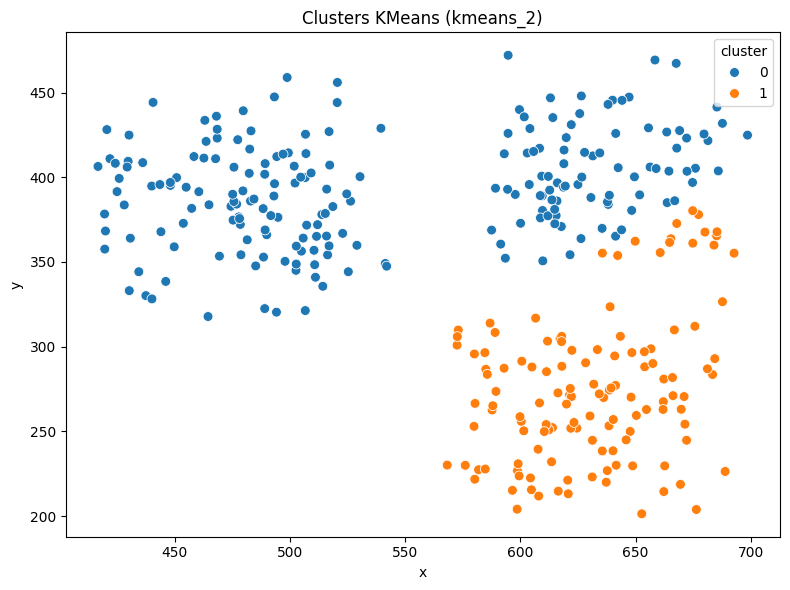

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pred_df, x="x", y="y", hue="prediction", palette="tab10", s=50)
plt.title(f"Clusters KMeans ({best_kmeans_name})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

In [ ]:
best_gmm_name, best_gmm_info = best["gmm"]
gmm_pred_pd = best_gmm_info["pred"].select("x","y","probability").toPandas()

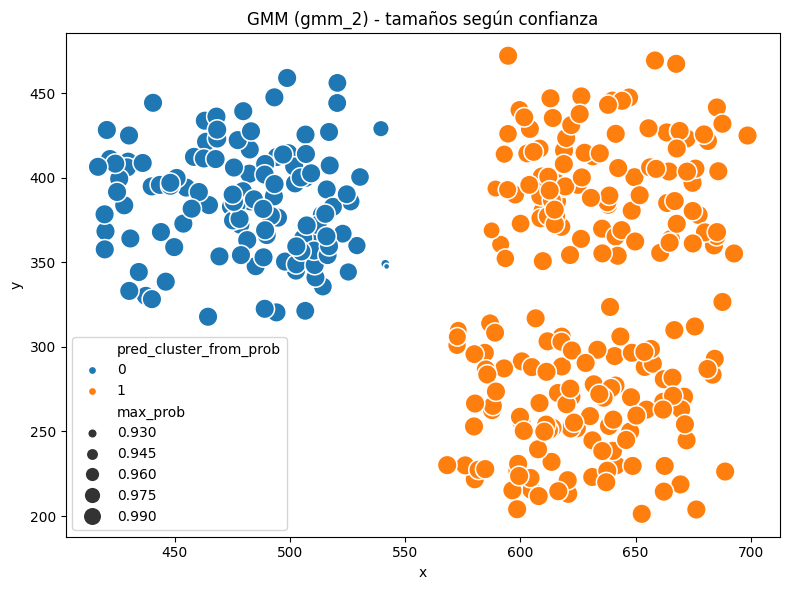

In [ ]:
gmm_pred_pd["max_prob"] = gmm_pred_pd["probability"].apply(lambda v: float(np.max(v)))
gmm_pred_pd["pred_cluster_from_prob"] = gmm_pred_pd["probability"].apply(lambda v: int(np.argmax(v)))
plt.figure(figsize=(8,6))
sns.scatterplot(data=gmm_pred_pd, x="x", y="y", hue="pred_cluster_from_prob", size="max_prob", sizes=(20,200))
plt.title(f"GMM ({best_gmm_name}) - tamaños según confianza")
plt.tight_layout()
plt.show()

In [ ]:
cluster_stats = pred_df.groupby("prediction").agg({"x":"mean","y":"mean","prediction":"count"}).rename(columns={"prediction":"count"})
print(cluster_stats)

                     x           y  count
prediction                               
0           544.264298  393.826648    209
1           631.149960  275.260487    127


In [ ]:
out_path = "/content/clustering_results/kmeans_best"
best_kmeans_info["pred"].select("x","y","prediction").write.mode("overwrite").option("header","true").csv(out_path)

In [ ]:
model_out = "/content/clustering_models/kmeans_best"
best_kmeans_info["model"].write().overwrite().save(model_out)